In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py
import cv2

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.3.1'

In [4]:
from imutils import paths
IMG_PATH = 'new dataset'
images_path = list(paths.list_images(IMG_PATH))
import os
import cv2
import numpy as np

In [5]:
def load(path):
    data = []
    labels = []
    # loop over the input image
    for (i, imgpath) in enumerate(path):
        gray_img = cv2.imread(imgpath)
        image = cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (160, 160))
        image = np.array(image)
        label = imgpath.split(os.path.sep)[-2]
        data.append(image)
        labels.append(label)
    # return a tuple of data and label
    return data, labels

In [6]:
image_list, label_list = load(images_path)

In [7]:
image_list[0].shape

(160, 160, 3)

In [8]:
label_list_numerical = []
for i in label_list:
    if i == 'glioma':
        label_list_numerical.append(2)
    elif i == 'meningioma':
        label_list_numerical.append(1)
    elif i == 'pituitary':
        label_list_numerical.append(3)

In [9]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

In [10]:
label_list[0]

array([1, 0, 0])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train,Y_test = train_test_split(
    image_list, 
    label_list,
    test_size = 0.1,
    random_state = 42)

In [12]:
print(len(X_train))
print(len(Y_train))

2757
2757


In [13]:
import tensorflow as tf
#process and batch the test data
test_batch = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(16)

In [14]:
tf.config.run_functions_eagerly(True)

In [15]:
#process and batch the train data
train_batch = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(16)

In [16]:
#Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_batch.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_batch.prefetch(buffer_size=AUTOTUNE)

In [17]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [18]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [19]:
#IMG_SHAPE = image_list[0].shape
base_model = tf.keras.applications.VGG16(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

In [20]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [22]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

In [23]:
prediction_layer.get_config()

{'name': 'dense',
 'trainable': True,
 'dtype': 'float32',
 'units': 3,
 'activation': 'softmax',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [24]:
inputs = tf.keras.Input(shape=(160,160, 3))
x = preprocess_input(inputs)
x = img_augmentation(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 160, 160, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)              

In [27]:
initial_epochs = 20

In [28]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18353882064421980344
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14433212219009039292
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4677514815891421567
physical_device_desc: "device: XLA_GPU device"
]


In [29]:
history = model.fit(train_dataset, epochs=initial_epochs,validation_data=test_dataset)

Epoch 1/20
173/173 [==============================] - 1478s 9s/step - loss: 1.3419 - accuracy: 0.4621 - val_loss: 1.3274 - val_accuracy: 0.4625
Epoch 2/20
173/173 [==============================] - 1489s 9s/step - loss: 1.0677 - accuracy: 0.5600 - val_loss: 1.0084 - val_accuracy: 0.5472
Epoch 3/20
173/173 [==============================] - 1471s 9s/step - loss: 0.9939 - accuracy: 0.5948 - val_loss: 0.8995 - val_accuracy: 0.5961
Epoch 4/20
173/173 [==============================] - 1460s 8s/step - loss: 0.8727 - accuracy: 0.6496 - val_loss: 0.8380 - val_accuracy: 0.6547
Epoch 5/20
173/173 [==============================] - 1473s 9s/step - loss: 0.7913 - accuracy: 0.6783 - val_loss: 0.8094 - val_accuracy: 0.6515
Epoch 6/20
173/173 [==============================] - 1460s 8s/step - loss: 0.7627 - accuracy: 0.6855 - val_loss: 0.7764 - val_accuracy: 0.6645
Epoch 7/20
173/173 [==============================] - 1454s 8s/step - loss: 0.7381 - accuracy: 0.6979 - val_loss: 0.7680 - val_accuracy:

In [30]:
acc = history.history['accuracy']
print(acc)

[0.4620964825153351, 0.5600290298461914, 0.5948494672775269, 0.6496191620826721, 0.6782734990119934, 0.6855277419090271, 0.6978600025177002, 0.7080159783363342, 0.7290533185005188, 0.7232499122619629, 0.7363075613975525, 0.7305041551589966, 0.7421109676361084, 0.7577076554298401, 0.7602466344833374, 0.7591584920883179, 0.7725788950920105, 0.771490752696991, 0.7747551798820496, 0.7798331379890442]


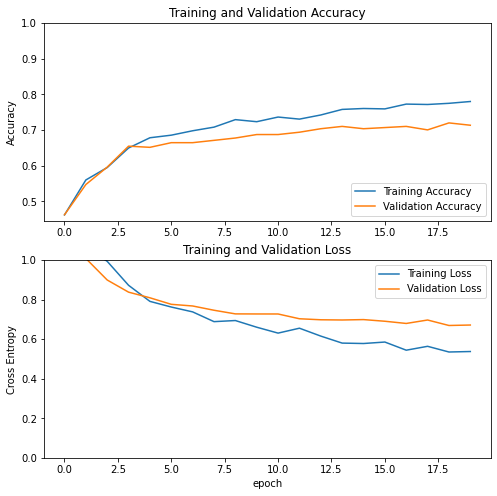

<Figure size 432x288 with 0 Axes>

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('accuracy-loss-vgg16.png')

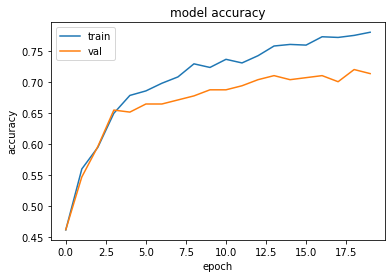

<Figure size 432x288 with 0 Axes>

In [32]:
from matplotlib import pyplot as plt
#plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('accuracy_curve_vgg16.png')

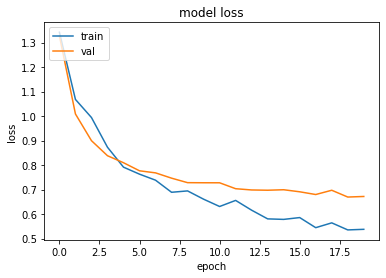

<Figure size 432x288 with 0 Axes>

In [33]:
#plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('loss_curve_vgg16.png')

In [44]:
#test_batch = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(4)

In [45]:
#loss, accuracy = model.evaluate(test_dataset)
#print('Test accuracy :', accuracy)

77/77 [==============================] - 26s 337ms/step - loss: 0.4075 - accuracy: 0.8762
Test accuracy : 0.8762214779853821


In [108]:
#test_dataset = test_batch.prefetch(buffer_size=AUTOTUNE)

In [110]:
#loss

0.28440072420718415

In [34]:
import tensorflow as tf

In [46]:
#model.save("model-efficientnet-image-size-224-with-augmentation.h5")

In [18]:
# load model
#model = load_model('model-efficient-net.h5')
# summarize model.
#model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1, 1, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [29]:
#from tensorflow.keras.models import load_model

In [31]:
# load model
#model = load_model('model-efficientnet-image-size-224-with-augmentation.h5')
# summarize model.
#model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                

In [32]:
#loss, accuracy = model.evaluate(test_dataset)
#print('Test accuracy :', accuracy)

20/20 [==============================] - 17s 860ms/step - loss: 0.4075 - accuracy: 0.8762
Test accuracy : 0.8762214779853821


In [35]:
pred_prob = model.predict(test_dataset)

In [36]:
pred_prob

array([[4.44787472e-01, 3.88683617e-01, 1.66528881e-01],
       [7.25938261e-01, 2.61408955e-01, 1.26526924e-02],
       [1.19513953e-02, 9.17613387e-01, 7.04351440e-02],
       [9.95026454e-02, 6.09582305e-01, 2.90914983e-01],
       [1.17786869e-01, 4.20681387e-01, 4.61531729e-01],
       [9.72173691e-01, 1.65982824e-02, 1.12280035e-02],
       [3.14998999e-03, 5.60916737e-02, 9.40758288e-01],
       [4.79009956e-01, 4.86062229e-01, 3.49277370e-02],
       [2.14771003e-01, 2.83413529e-02, 7.56887615e-01],
       [3.61666948e-01, 5.05093455e-01, 1.33239552e-01],
       [2.22499579e-01, 7.52107978e-01, 2.53923777e-02],
       [8.22417997e-03, 3.40070091e-02, 9.57768857e-01],
       [2.71851122e-01, 1.24357514e-01, 6.03791296e-01],
       [1.14935927e-01, 7.34193623e-01, 1.50870427e-01],
       [1.98106822e-02, 1.14999488e-01, 8.65189850e-01],
       [3.36849317e-03, 2.92618386e-02, 9.67369676e-01],
       [4.09296015e-03, 3.20244908e-01, 6.75662160e-01],
       [2.69446359e-03, 1.49576

In [37]:
n_classes = 3

In [38]:
#Multiclass ROC curve
from scipy import interp
from sklearn.metrics import roc_auc_score

In [39]:
from sklearn.metrics import roc_curve, auc

In [40]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [41]:
roc_auc

{0: 0.9277990634312473, 1: 0.8214370971592264, 2: 0.9482600732600732}

In [42]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [43]:
roc_auc

{0: 0.9277990634312473,
 1: 0.8214370971592264,
 2: 0.9482600732600732,
 'micro': 0.8870014535963245}

In [44]:
#compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [45]:
roc_auc

{0: 0.9277990634312473,
 1: 0.8214370971592264,
 2: 0.9482600732600732,
 'micro': 0.8870014535963245,
 'macro': 0.9017227681055541}

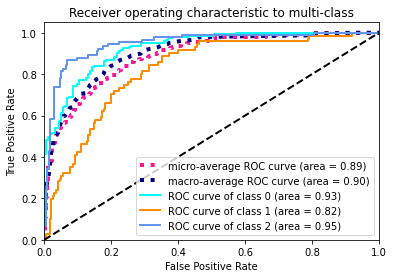

<Figure size 432x288 with 0 Axes>

In [46]:
from itertools import cycle
# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc-vgg16.png')

In [47]:
y_pred= np.argmax(pred_prob,axis=1)

In [48]:
y_pred

array([0, 0, 1, 1, 2, 0, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 2, 1, 0, 1, 2, 2, 0, 2, 2, 0, 2, 1, 1, 1, 0, 0, 0, 2, 2, 0, 2,
       2, 2, 0, 1, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0,
       0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 2, 2, 0, 0, 0, 2,
       0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0, 2, 2, 0, 2, 2, 1, 0,
       0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 2, 1, 2, 2, 0, 0, 2, 1, 2, 0, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2,
       0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 1, 2, 2, 0, 1, 2, 0, 0, 1, 0, 2,
       2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0,
       2, 0, 2, 2, 1, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 0, 2, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 1, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 0,
       0, 2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0, 2, 0, 0,
       2, 1, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1, 2, 1, 0, 1, 2, 0, 0,
       1, 2, 0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0,

In [49]:
y_test = np.argmax(Y_test, axis=1)

In [50]:
y_test 

array([0, 0, 0, 1, 1, 0, 2, 1, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2,
       2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0,
       0, 1, 2, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 0, 2,
       0, 0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 2, 2, 0, 0,
       1, 0, 0, 2, 1, 0, 2, 2, 0, 2, 1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 2, 1, 2, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2, 2, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 0, 0,
       1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2, 0, 0, 0, 1, 0, 1, 2, 0,
       2, 0, 0, 1, 1, 0, 0, 2, 0, 2, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 0,
       2, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0,
       0, 1, 1, 0, 0, 2, 1, 1, 2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 0,
       1, 2, 0, 1, 0, 2, 2, 1, 1, 0, 2, 0, 0, 0, 0,

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [52]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)

Accuracy: 0.713355


In [53]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred,average=None)
#print('Precision: %f' % precision)

In [54]:
precision

array([0.87394958, 0.54716981, 0.63703704])

In [55]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average = None)
#print('Recall: %f' % recall)

In [56]:
recall

array([0.71724138, 0.4084507 , 0.94505495])

In [57]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average = None)
#print('F1 score: %f' % f1)

In [58]:
f1

array([0.78787879, 0.46774194, 0.76106195])

In [59]:
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[104  20  21]
 [ 14  29  28]
 [  1   4  86]]


In [48]:
import pickle

In [49]:
# save:
#f = open('history-efficientnet-image-size-224-with-augmentation.pckl', 'wb')
#pickle.dump(history.history, f)
#f.close()

In [43]:
# retrieve:    
#f = open('history.pckl', 'rb')
#history2 = pickle.load(f)
#f.close()

In [44]:
#history == history2

False

In [45]:
#history.history == history2

True

In [46]:
#history2['accuracy']

[0.45955750346183777,
 0.6238664984703064,
 0.6851650476455688,
 0.7319550514221191,
 0.7461008429527283,
 0.7627856135368347,
 0.7733043432235718,
 0.7947043776512146,
 0.8012332320213318,
 0.807399332523346,
 0.8113892078399658,
 0.815741777420044,
 0.8258976936340332,
 0.8233587145805359,
 0.8251723051071167,
 0.8371418118476868,
 0.8338773846626282,
 0.8349655270576477,
 0.8487486243247986,
 0.8472977876663208]